## Imports

In [2]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns

## Data Transformation

In [63]:
path = r'/kaggle/input/422-analysis-10'
all_files = glob.glob(path + "/*.csv")

dfs = []
for filename in all_files:
    dfs.append(pd.read_csv(filename))

## Table Builder

In [64]:
def table_builder(f1_type, precision_type, recall_type, df):
    filtered_result = df[df["key"] == f1_type]

    # get the index of the row with the maximum value of "value_mean"
    max_index = filtered_result["value_mean"].idxmax()

    # get the corresponding value of "step"
    max_step = filtered_result.loc[max_index, "step"]

    # filter the DataFrame again to only include rows with the same "step" value
    same_step_df = df[df["step"] == max_step]

    # extract the values of the other columns
    scenario = filtered_result.loc[max_index, "scenario"]
    max_f1_score = filtered_result.loc[max_index, "value_mean"]
    max_std = filtered_result.loc[max_index, "value_std"]
    max_precision = same_step_df[same_step_df["key"] == precision_type]["value_mean"].values[0]
    std_precision = same_step_df[same_step_df["key"] == precision_type]["value_std"].values[0]
    max_recall = same_step_df[same_step_df["key"] == recall_type]["value_mean"].values[0]
    std_recall = same_step_df[same_step_df["key"] == recall_type]["value_std"].values[0]

    # create a new DataFrame with the desired format
    f1_result = pd.DataFrame({"scenario": [scenario],
                            f1_type: [max_f1_score],
                           "std_f1": [max_std],
                           precision_type: [max_precision],
                           "std_precision": [std_precision],
                           recall_type: [max_recall],
                           "std_recall": [std_recall],
                           "step": [max_step]})

    return f1_result

#### F1-Score Macro

In [65]:
f1_macro = []
for i in range(len(all_files)):
    f1_macro.append(table_builder(f1_type="test_f1_score_macro",
                         precision_type="test_precision_macro",
                         recall_type="test_recall_macro",
                         df = dfs[i]))

macro_df = pd.concat(f1_macro, axis=0, ignore_index=True)
macro_df.sort_values('scenario', ascending=True)

,scenario,test_f1_score_macro,std_f1,test_precision_macro,std_precision,test_recall_macro,std_recall,step
2,scenario 2,0.744595,0.005353,0.760156,0.009845,0.740383,0.008214,50
0,scenario 4 - dcgan,0.741565,0.012593,0.762139,0.009375,0.735488,0.015253,20
1,scenario 5 - dcgan,0.749086,0.008415,0.758885,0.011817,0.750566,0.007446,11


#### F1-Score Weighted

In [66]:
f1_weight = []
for i in range(len(all_files)):
    f1_weight.append(table_builder(f1_type="test_f1_score_weight",
                         precision_type="test_precision_weight",
                         recall_type="test_recall_weight",
                         df = dfs[i]))

weight_df = pd.concat(f1_weight, axis=0, ignore_index=True)
weight_df.sort_values('scenario', ascending=True)

,scenario,test_f1_score_weight,std_f1,test_precision_weight,std_precision,test_recall_weight,std_recall,step
2,scenario 2,0.809099,0.006836,0.814299,0.006282,0.808831,0.007265,56
0,scenario 4 - dcgan,0.806603,0.009868,0.810532,0.009432,0.809069,0.009968,58
1,scenario 5 - dcgan,0.809602,0.007463,0.814175,0.006852,0.810382,0.007784,55


## Chart Builder

In [67]:
df = pd.concat(dfs, axis=0, ignore_index=True).drop('Unnamed: 0', axis=1)
df

,key,step,value_mean,value_std,scenario
0,test_f1_score_macro,0,0.582452,0.029510,scenario 4 - dcgan
1,test_f1_score_macro,1,0.675354,0.011591,scenario 4 - dcgan
2,test_f1_score_macro,2,0.708794,0.011573,scenario 4 - dcgan
3,test_f1_score_macro,3,0.708520,0.009466,scenario 4 - dcgan
4,test_f1_score_macro,4,0.724967,0.010460,scenario 4 - dcgan
...,...,...,...,...,...
1345,test_recall_weight,70,0.805251,0.010920,scenario 2
1346,test_recall_weight,71,0.805967,0.007799,scenario 2
1347,test_recall_weight,72,0.804773,0.005223,scenario 2
1348,test_recall_weight,73,0.802864,0.006507,scenario 2


In [80]:
def plot_chart(key, df, axis):
    # set the key and column names
    key = key
    value_col = 'value_mean'
    scenario_col = 'scenario'

    # filter the result dataframe by the key
    filtered_result = df[df['key'] == key]

    # get the list of unique scenarios
    scenarios = filtered_result[scenario_col].unique().tolist()
    scenarios.sort()

    # set the plot style
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    custom_palette = sns.color_palette("bright")
    custom_colors = [custom_palette[1], custom_palette[3], custom_palette[4]]
    sns.set_palette(custom_colors)
    
    # plot the lines for each scenario
    fig, ax = plt.subplots()
    for scenario in scenarios:
        # filter the result dataframe by the scenario
        scenario_result = filtered_result[filtered_result[scenario_col] == scenario]
#         check if the label contains "scenario 3" and set the line style accordingly
#         if "scenario 3" in scenario:
#             linestyle = "dotted"
#         elif "scenario 4" in scenario:
#             linestyle = "--"
#         else:
#             linestyle = "-"
#         plot the mean value with shaded error band
        ax.plot(scenario_result['step'], scenario_result[value_col], linewidth=1, 
                label=scenario.upper())
        ax.fill_between(scenario_result['step'], 
                        scenario_result[value_col] - scenario_result['value_std'], 
                        scenario_result[value_col] + scenario_result['value_std'], 
                        alpha=0.15)

        
    max_val = filtered_result[value_col].max()
    min_val = filtered_result[value_col].min()
    
#     ax.axhline(y=max_val, linestyle='--', color='gray', alpha=0.5)
#     ax.axhline(y=min_val, linestyle='--', color='gray', alpha=0.5)

#     ax.set_ylim([0.5,0.77])
#     ax.set_ylim([0.55,0.83])
    ax.set_ylim([0.0,0.77])
    
    # set the text color to black
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    
    # set the plot labels and legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])
    ax.set_xlabel('Training epochs')
#     ax.set_ylabel(f'{key.replace("_", " " ).title()}')
    ax.set_ylabel(f'{axis} test F1-Score')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    plt.savefig(f'{key}.png', dpi=500, bbox_inches='tight')
    plt.savefig(f'{key}.pdf', format='pdf', dpi=800, bbox_inches='tight')
    plt.show()

## Metrics x Epochs

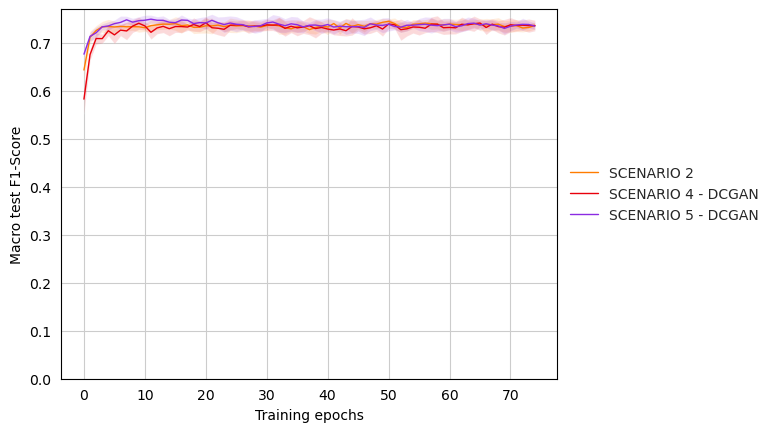

In [81]:
#F1 Score Macro
plot_chart(key="test_f1_score_macro", df=df, axis="Macro")

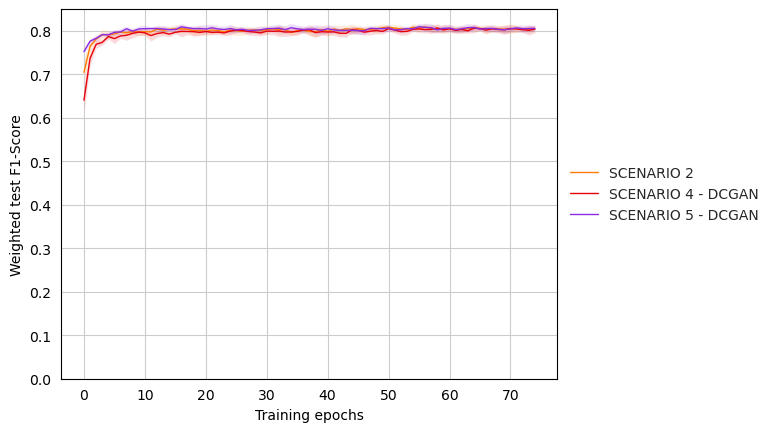

In [77]:
#F1 Score Weighted
plot_chart(key="test_f1_score_weight", df=df, axis="Weighted")

In [62]:
def plot_chart(key, df, axis):
    # set the key and column names
    key = key
    value_col = 'value_mean'
    scenario_col = 'scenario'

    # filter the result dataframe by the key
    filtered_result = df[df['key'] == key]

    # get the list of unique scenarios
    scenarios = filtered_result[scenario_col].unique().tolist()
    scenarios.sort()

    # set the plot style
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    custom_palette = sns.color_palette("bright")
    
    # plot the lines for each scenario
    fig, ax = plt.subplots()
    for scenario in scenarios:
        # filter the result dataframe by the scenario
        scenario_result = filtered_result[filtered_result[scenario_col] == scenario]
#         check if the label contains "scenario 3" and set the line style accordingly
        if "scenario 3" in scenario:
            linestyle = "dotted"
        elif "scenario 4" in scenario:
            linestyle = "--"
        else:
            linestyle = "-"
#         plot the mean value with shaded error band
        ax.plot(scenario_result['step'], scenario_result[value_col], linewidth=1, 
                label=scenario.upper(), linestyle=linestyle)

        
    max_val = filtered_result[value_col].max()
    min_val = filtered_result[value_col].min()
    

#     ax.set_ylim([0.5,0.77])
#     ax.set_ylim([0.55,0.83])
#     ax.set_ylim([0.0,0.77])
    
    # set the text color to black
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    
    # set the plot labels and legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])
    ax.set_xlabel('Training epochs')
    ax.set_ylabel(f'{axis} test F1-Score')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    plt.savefig(f'{key}.pdf', format='pdf', dpi=800, bbox_inches='tight')
    plt.show()

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

def plot_chart(key, df, axis, axis_size):
    # set the key and column names
    key = key
    value_col = 'value_mean'
    scenario_col = 'scenario'

    # filter the result dataframe by the key
    filtered_result = df[df['key'] == key]

    # get the list of unique scenarios
    scenarios = filtered_result[scenario_col].unique().tolist()
    scenarios.sort()

    # set the plot style
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    custom_palette = sns.color_palette("bright")
    
    # create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
    
#     fig.subplots_adjust(wspace=40)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # adjust the width ratios as per your preference
    
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    # plot the lines for each scenario on the first subplot
    for scenario in scenarios:
        # filter the result dataframe by the scenario
        scenario_result = filtered_result[filtered_result[scenario_col] == scenario]
        # check if the label contains "scenario 3" and set the line style accordingly
        if "scenario 3" in scenario:
            linestyle = "dotted"
        elif "scenario 4" in scenario:
            linestyle = "--"
        else:
            linestyle = "-"
        # plot the mean value with shaded error band on the first subplot
        ax1.plot(scenario_result['step'], scenario_result[value_col], linewidth=2, 
                 label=scenario.upper(), linestyle=linestyle)
        ax2.plot(scenario_result['step'], scenario_result[value_col], linewidth=2, 
                 label=scenario.upper(), linestyle=linestyle)

    
    # set the y-axis range for the second subplot
    ax1.set_ylim([0.0, 0.77])
    ax2.set_ylim([0.5, 0.77])
    
    # set the text color to black for both subplots
    ax1.xaxis.label.set_color('black')
    ax1.yaxis.label.set_color('black')
    ax1.title.set_color('black')
    ax1.tick_params(axis='x', colors='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.tick_params(axis='both', labelsize=axis_size)

    
    ax2.xaxis.label.set_color('black')
    ax2.yaxis.label.set_color('black')
    ax2.title.set_color('black')
    ax2.tick_params(axis='x', colors='black')
    ax2.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='both', labelsize=axis_size)
    
    # set the plot labels and legend for the first subplot
    ax1.set_xlabel('Training epochs',  fontsize=axis_size)
    ax1.set_ylabel(f'{axis} test F1-Score',  fontsize=axis_size)
    ax1.legend().remove()

    ax2.set_xlabel('Training epochs', fontsize=axis_size)
#     ax2.set_ylabel(f'{axis} test F1-Score', fontsize=axis_size)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=axis_size)
    
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')

    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    plt.tight_layout()  # adjust spacing between subplots
    plt.savefig(f'{key}.pdf', format='pdf', dpi=800, bbox_inches='tight')
    plt.show() 

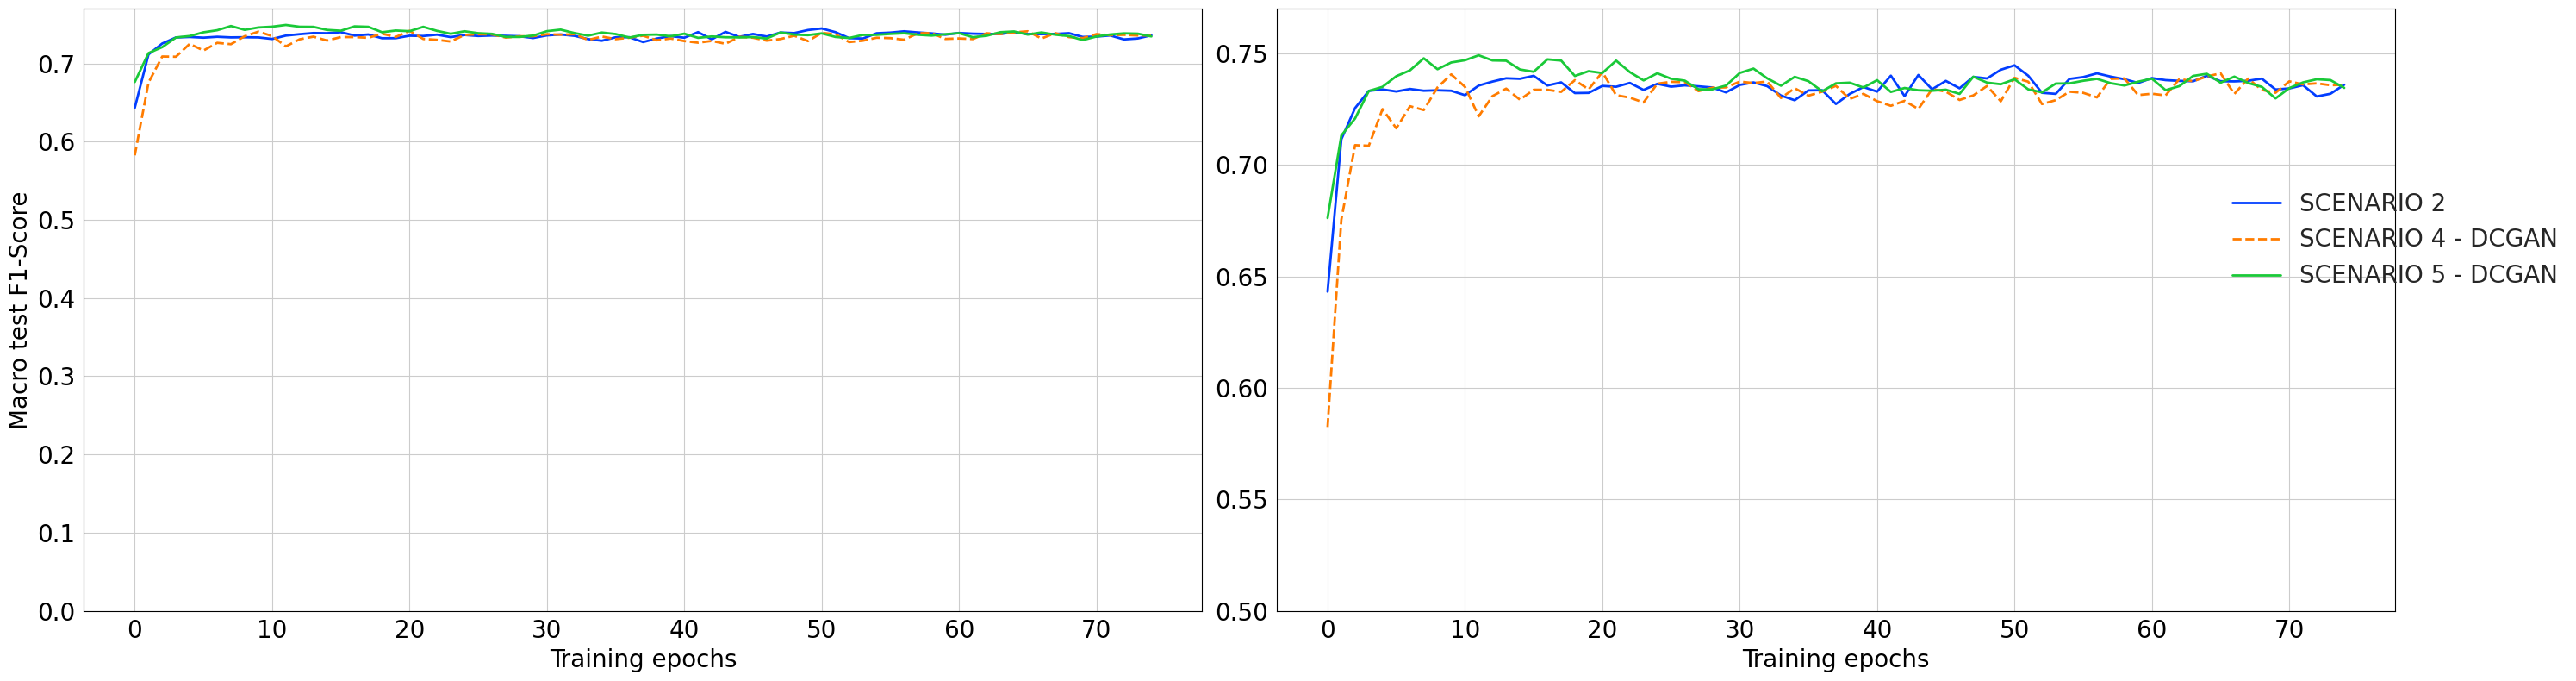

In [24]:
#F1 Score Macro
plot_chart(key="test_f1_score_macro", df=df, axis="Macro", axis_size=20)